In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report
import math
import numpy as np

from sklearn.preprocessing import StandardScaler
#from yellowbrick.regressor import ResidualsPlot

##  Carrega dados

In [2]:
df = pd.read_csv("data/apartamentos_completo.csv")

df = df.drop(['Unnamed: 0'],axis=1)
df.reset_index(inplace=True,drop=True)
print(df.shape)
df.head()

(30748, 17)


,nome,valor_venda,url,condominio,IPTU,lat,long,area_total,area_util,banheiros,vagas,quartos,suites,idade,endereco,bairro,idade_anuncio
0,Tower duplex 90m2,550000,https://www.wimoveis.com.br/propriedades/tower...,R$ 730,R$ 690,-15.842635250484830,-48.024645807548495,89m²,89m²,3.0,2.0,2.0,2.0,6,"Qd 206, Aguas Sul, Águas Claras",", Aguas Sul, Águas Claras",52
1,SELECTION 36,2150000,https://www.wimoveis.com.br/propriedades/selec...,NaN,NaN,-15.742129999999999,-47.910919999999997,224m²,224m²,6.0,3.0,4.0,4.0,4,"Quadra SQNW 110, Noroeste, Brasília",", Noroeste, Brasília",6
2,Elevador + Apartamento de 3 Quartos + Excelent...,420000,https://www.wimoveis.com.br/propriedades/eleva...,NaN,NaN,-15.739203900000000,-47.902473900000020,NaN,65m²,2.0,0.0,3.0,0.0,NaN,SCRN 706/707 BLOCO F - COMPLETO ARMÁRIOS- EXCE...,", Asa Norte, Brasília",9
3,"01, 02 QUARTOS E LOJA COMERCIAL - MEET NOROESTE",332420,https://www.wimoveis.com.br/propriedades/01-02...,NaN,NaN,-15.748856500000000,-47.896520000000010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14
4,Elegance Park Sul de 03 Suítes,1333800,https://www.wimoveis.com.br/propriedades/elega...,NaN,NaN,-15.827143900000000,-47.952883600000010,117m²,117m²,5.0,2.0,3.0,3.0,1,"Sgcv 23, Park Sul, Brasília",", Park Sul, Brasília",8


In [3]:
df.dtypes

nome              object
valor_venda        int64
url               object
condominio        object
IPTU              object
lat               object
long              object
area_total        object
area_util         object
banheiros        float64
vagas            float64
quartos          float64
suites           float64
idade             object
endereco          object
bairro            object
idade_anuncio     object
dtype: object

### Dropa imoveis que não tem latitude, longitude e área útil

In [4]:
df.dropna(subset=['lat', 'long','area_util','bairro'],inplace=True)
df.shape

(25493, 17)

### Quantidade de valores nulos por coluna

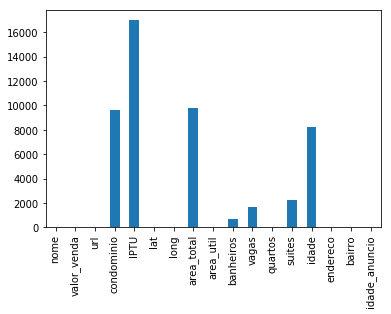

In [5]:
df.isna().sum().plot.bar()

In [6]:
df.isna().sum()

nome                 0
valor_venda          0
url                  0
condominio        9597
IPTU             16985
lat                  0
long                 0
area_total        9786
area_util            0
banheiros          642
vagas             1691
quartos             24
suites            2206
idade             8253
endereco             0
bairro               0
idade_anuncio        0
dtype: int64

### Remove outliers do preço de venda

In [7]:
print(df.shape)
df.valor_venda.describe()

(25493, 17)


count    2.549300e+04
mean     2.591094e+06
std      6.194202e+07
min      1.440000e+02
25%      2.800000e+05
50%      4.800000e+05
75%      1.000000e+06
max      6.299000e+09
Name: valor_venda, dtype: float64

### 6 bilhões parece muito para um imóvel
Vamos remover aqueles que custam a partir de 65 milhões

In [8]:
df = df.loc[df.valor_venda < 65000000]
print(df.shape)
df.valor_venda.describe()

(25422, 17)


count    2.542200e+04
mean     7.602199e+05
std      7.618316e+05
min      1.440000e+02
25%      2.800000e+05
50%      4.800000e+05
75%      1.000000e+06
max      1.200000e+07
Name: valor_venda, dtype: float64

### Remove outliers da area util

In [9]:
df.area_util = df.area_util.str.replace('m²','')
df.area_util = pd.to_numeric(df.area_util)

In [10]:
print(df.shape)
df.area_util.describe()

(25422, 17)


count     25422.000000
mean        115.355598
std        1274.183473
min           1.000000
25%          56.000000
50%          78.000000
75%         123.000000
max      143167.000000
Name: area_util, dtype: float64

## 143mil m2  parece muito para um apartamento
Vamos remover aqueles que sao maiores que 9 mil m2

In [11]:
df = df.loc[df.area_util < 9000]
print(df.shape)
df.area_util.describe()

(25418, 17)


count    25418.000000
mean       101.669014
std        152.433743
min          1.000000
25%         56.000000
50%         78.000000
75%        123.000000
max       8250.000000
Name: area_util, dtype: float64

### Checa distribuição dos Bairros

In [12]:
df.bairro = df.bairro.str.replace(",  ","")
df.bairro.value_counts()

Aguas Sul, Águas Claras                                3485
Noroeste, Brasília                                     3413
Aguas Norte, Águas Claras                              3020
Asa Norte, Brasília                                    2973
Asa Sul, Brasília                                      2247
Sudoeste, Brasília                                     1538
Taguatinga Norte, Taguatinga                            815
Park Sul, Brasília                                      707
Guara II, Guará                                         609
Samambaia Sul, Samambaia                                501
Setor Marista, Goiânia                                  465
Areal, Águas Claras                                     465
Lago Norte, Brasília                                    443
Taguatinga Sul, Taguatinga                              423
Setor Bueno, Goiânia                                    391
Guara I, Guará                                          261
Samambaia Norte, Samambaia              

In [13]:
bairros_goiania = ['Setor Bueno, Goiânia','Setor Marista, Goiânia','Jardim Goiás, Goiânia','Setor Oeste, Goiânia',
                  'Parque Amazônia, Goiânia','Jardim América, Goiânia']
df = df[~df['bairro'].isin(bairros_goiania)]
df.bairro.value_counts()

Aguas Sul, Águas Claras                                3485
Noroeste, Brasília                                     3413
Aguas Norte, Águas Claras                              3020
Asa Norte, Brasília                                    2973
Asa Sul, Brasília                                      2247
Sudoeste, Brasília                                     1538
Taguatinga Norte, Taguatinga                            815
Park Sul, Brasília                                      707
Guara II, Guará                                         609
Samambaia Sul, Samambaia                                501
Areal, Águas Claras                                     465
Lago Norte, Brasília                                    443
Taguatinga Sul, Taguatinga                              423
Guara I, Guará                                          261
Samambaia Norte, Samambaia                              252
Cruzeiro Novo, Cruzeiro                                 212
Centro, Brasília                        

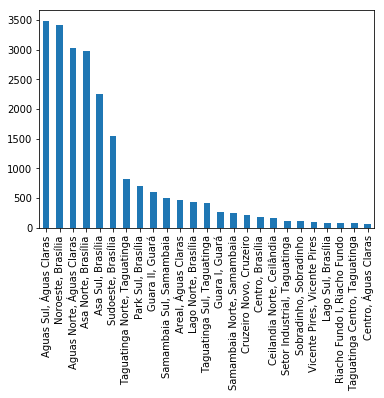

In [14]:
df.bairro.value_counts()[:25].plot.bar()

### Remove bairros com menos imóveis (pega so 25 +)

In [15]:
df.bairro.value_counts()[25:]

Setor De Clubes Esportivos Norte, Brasília             64
Quadras Economicas Lucio Costa, Guará                  63
Octogonal, Brasília                                    57
Nucleo Bandeirante, Núcleo Bandeirante                 56
QE Lucio Costa, Guará                                  39
Águas Claras, Distrito Federal                         39
Setor Central, Gama                                    38
Centro, Taguatinga                                     38
Setor Industrial, Gama                                 38
Grande Colorado, Sobradinho                            38
Setor Nova Suiça, Goiânia                              36
Setor Bela Vista, Goiânia                              35
Ceilandia Sul, Ceilândia                               32
Setor Pedro Ludovico, Goiânia                          32
Samambaia, Samambaia                                   31
Setor Leste Universitário, Goiânia                     31
Setor Central, Goiânia                                 27
Turista I, Cal

In [16]:
bairros_reject = df.bairro.value_counts()[25:].index.values
bairros_reject

array(['Setor De Clubes Esportivos Norte, Brasília',
       'Quadras Economicas Lucio Costa, Guará', 'Octogonal, Brasília',
       'Nucleo Bandeirante, Núcleo Bandeirante', 'QE Lucio Costa, Guará',
       'Águas Claras, Distrito Federal', 'Setor Central, Gama',
       'Centro, Taguatinga', 'Setor Industrial, Gama',
       'Grande Colorado, Sobradinho', 'Setor Nova Suiça, Goiânia',
       'Setor Bela Vista, Goiânia', 'Ceilandia Sul, Ceilândia',
       'Setor Pedro Ludovico, Goiânia', 'Samambaia, Samambaia',
       'Setor Leste Universitário, Goiânia', 'Setor Central, Goiânia',
       'Turista I, Caldas Novas', 'Alto da Glória, Goiânia',
       'Parque Esplanada III, Valparaíso de Goiás',
       'Riacho Fundo, Riacho Fundo', 'Zona Industrial, Guará',
       'Setor de Hotéis e Turismo Norte, Brasília',
       'Cruzeiro Velho, Cruzeiro', 'Superquadra Noroeste, Brasília',
       'Jardim Atlântico, Goiânia',
       'Parque Esplanada II, Valparaíso de Goiás',
       'Residencial Eldorado, Goi

In [17]:
df = df[~df['bairro'].isin(bairros_reject)]
print(df.shape)
df.head()

(22342, 17)


,nome,valor_venda,url,condominio,IPTU,lat,long,area_total,area_util,banheiros,vagas,quartos,suites,idade,endereco,bairro,idade_anuncio
0,Tower duplex 90m2,550000,https://www.wimoveis.com.br/propriedades/tower...,R$ 730,R$ 690,-15.842635250484830,-48.024645807548495,89m²,89,3.0,2.0,2.0,2.0,6,"Qd 206, Aguas Sul, Águas Claras","Aguas Sul, Águas Claras",52
1,SELECTION 36,2150000,https://www.wimoveis.com.br/propriedades/selec...,NaN,NaN,-15.742129999999999,-47.910919999999997,224m²,224,6.0,3.0,4.0,4.0,4,"Quadra SQNW 110, Noroeste, Brasília","Noroeste, Brasília",6
2,Elevador + Apartamento de 3 Quartos + Excelent...,420000,https://www.wimoveis.com.br/propriedades/eleva...,NaN,NaN,-15.739203900000000,-47.902473900000020,NaN,65,2.0,0.0,3.0,0.0,NaN,SCRN 706/707 BLOCO F - COMPLETO ARMÁRIOS- EXCE...,"Asa Norte, Brasília",9
4,Elegance Park Sul de 03 Suítes,1333800,https://www.wimoveis.com.br/propriedades/elega...,NaN,NaN,-15.827143900000000,-47.952883600000010,117m²,117,5.0,2.0,3.0,3.0,1,"Sgcv 23, Park Sul, Brasília","Park Sul, Brasília",8
5,QI 31 Jardins Life Reformadíssimo Localização ...,580000,https://www.wimoveis.com.br/propriedades/qi-31...,NaN,NaN,-15.840017800000000,-47.975002600000038,NaN,68,2.0,1.0,2.0,1.0,3,"QUADRA QI 31 LOTES 2/4, Guara II, Guará","Guara II, Guará",6


In [18]:
df.bairro.value_counts()

Aguas Sul, Águas Claras          3485
Noroeste, Brasília               3413
Aguas Norte, Águas Claras        3020
Asa Norte, Brasília              2973
Asa Sul, Brasília                2247
Sudoeste, Brasília               1538
Taguatinga Norte, Taguatinga      815
Park Sul, Brasília                707
Guara II, Guará                   609
Samambaia Sul, Samambaia          501
Areal, Águas Claras               465
Lago Norte, Brasília              443
Taguatinga Sul, Taguatinga        423
Guara I, Guará                    261
Samambaia Norte, Samambaia        252
Cruzeiro Novo, Cruzeiro           212
Centro, Brasília                  187
Ceilandia Norte, Ceilândia        167
Setor Industrial, Taguatinga      116
Sobradinho, Sobradinho            108
Vicente Pires, Vicente Pires       96
Lago Sul, Brasília                 79
Riacho Fundo I, Riacho Fundo       78
Taguatinga Centro, Taguatinga      76
Centro, Águas Claras               71
Name: bairro, dtype: int64

In [19]:
df.quartos = df.quartos.fillna(df.quartos.median())

In [20]:
df_regression = df[['bairro', 'area_util', 'quartos','valor_venda']]
print(df_regression.shape)
df_regression.head()

(22342, 4)


,bairro,area_util,quartos,valor_venda
0,"Aguas Sul, Águas Claras",89,2.0,550000
1,"Noroeste, Brasília",224,4.0,2150000
2,"Asa Norte, Brasília",65,3.0,420000
4,"Park Sul, Brasília",117,3.0,1333800
5,"Guara II, Guará",68,2.0,580000


In [21]:
df_regression.isna().sum()

bairro         0
area_util      0
quartos        0
valor_venda    0
dtype: int64

In [22]:
df_regression.head()

,bairro,area_util,quartos,valor_venda
0,"Aguas Sul, Águas Claras",89,2.0,550000
1,"Noroeste, Brasília",224,4.0,2150000
2,"Asa Norte, Brasília",65,3.0,420000
4,"Park Sul, Brasília",117,3.0,1333800
5,"Guara II, Guará",68,2.0,580000


In [23]:
one_hot = pd.get_dummies(df_regression['bairro'], prefix="bairro")
df_regression = df_regression.join(one_hot)

df_regression = df_regression.drop(['bairro'], axis=1)

df_regression.shape
df_regression.head()

,area_util,quartos,valor_venda,"bairro_Aguas Norte, Águas Claras","bairro_Aguas Sul, Águas Claras","bairro_Areal, Águas Claras","bairro_Asa Norte, Brasília","bairro_Asa Sul, Brasília","bairro_Ceilandia Norte, Ceilândia","bairro_Centro, Brasília",...,"bairro_Riacho Fundo I, Riacho Fundo","bairro_Samambaia Norte, Samambaia","bairro_Samambaia Sul, Samambaia","bairro_Setor Industrial, Taguatinga","bairro_Sobradinho, Sobradinho","bairro_Sudoeste, Brasília","bairro_Taguatinga Centro, Taguatinga","bairro_Taguatinga Norte, Taguatinga","bairro_Taguatinga Sul, Taguatinga","bairro_Vicente Pires, Vicente Pires"
0,89,2.0,550000,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,224,4.0,2150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,65,3.0,420000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,117,3.0,1333800,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,68,2.0,580000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
X = df_regression.drop(['valor_venda'],axis=1)
y = df_regression['valor_venda']
X.shape, y.shape

((22342, 27), (22342,))

In [25]:
X_columns = X.columns.values
X = pd.DataFrame(StandardScaler().fit_transform(X),columns=X_columns)

/home/user/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/user/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20107, 27), (2235, 27), (20107,), (2235,))

In [27]:
reg = RandomForestRegressor(n_estimators=100) 
reg

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [28]:
reg.fit(X_train, y_train)
train_predict = reg.predict(X_train)
test_predict = reg.predict(X_test)

In [29]:
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, test_predict))

print("Root Mean squared error: %.2f"
      % math.sqrt(mean_squared_error(y_test, test_predict)))

print('R2 score: %.2f' % r2_score(y_test, test_predict))

Mean squared error: 77975143258.16
Root Mean squared error: 279240.30
R2 score: 0.90


Feature ranking:
1. feature area_util (0.856388)
2. feature bairro_Aguas Sul, Águas Claras (0.031942)
3. feature quartos (0.025774)
4. feature bairro_Noroeste, Brasília (0.019120)
5. feature bairro_Aguas Norte, Águas Claras (0.015923)
6. feature bairro_Sudoeste, Brasília (0.014144)
7. feature bairro_Asa Norte, Brasília (0.008259)
8. feature bairro_Asa Sul, Brasília (0.005612)
9. feature bairro_Taguatinga Norte, Taguatinga (0.004745)
10. feature bairro_Park Sul, Brasília (0.003359)
11. feature bairro_Lago Sul, Brasília (0.002960)
12. feature bairro_Guara I, Guará (0.002121)
13. feature bairro_Areal, Águas Claras (0.001689)
14. feature bairro_Vicente Pires, Vicente Pires (0.001430)
15. feature bairro_Taguatinga Sul, Taguatinga (0.001386)
16. feature bairro_Guara II, Guará (0.001185)
17. feature bairro_Centro, Brasília (0.000941)
18. feature bairro_Lago Norte, Brasília (0.000900)
19. feature bairro_Samambaia Sul, Samambaia (0.000577)
20. feature bairro_Centro, Águas Claras (0.000475)
21. 

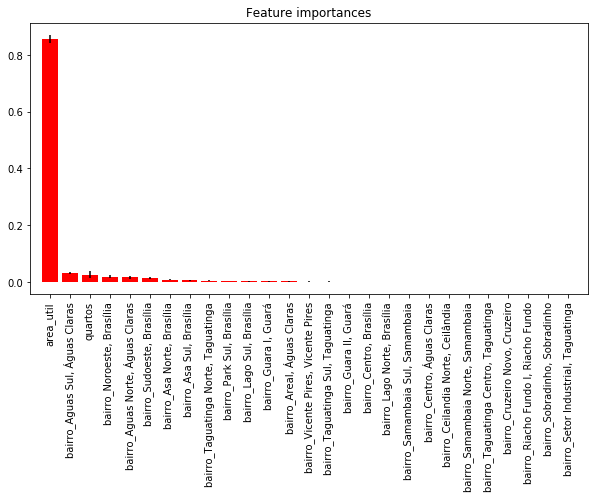

In [30]:
 plt.rcParams['figure.figsize'] = [10, 5]
importances = reg.feature_importances_
std = np.std([tree.feature_importances_ for tree in reg.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

#Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):

    print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [31]:
#reg2 = RandomForestRegressor(n_estimators=100) 

#visualizer = ResidualsPlot(reg2)
#visualizer.fit(X_train, y_train)  # Fit the training data to the model
#visualizer.score(X_test, y_test)  # Evaluate the model on the test data
#visualizer.poof()                 # Draw/show/poof the data

### TODO: scatterplot valor_venda x area util

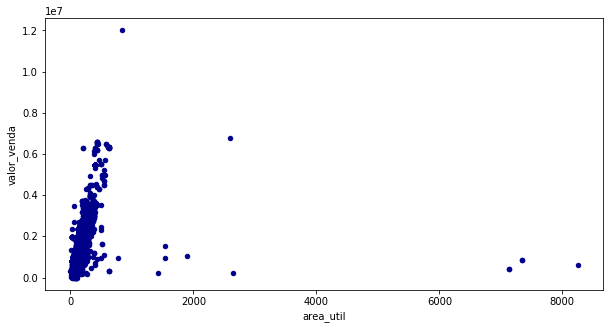

In [32]:

ax1 = df.plot.scatter(x='area_util',
                       y='valor_venda',
                       c='DarkBlue')

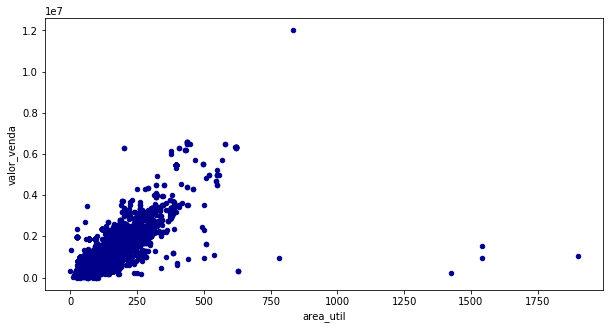

In [33]:
df_zoom = df.loc[df.area_util < 2001]
ax2 = df_zoom.plot.scatter(x='area_util',
                       y='valor_venda',
                       c='DarkBlue')

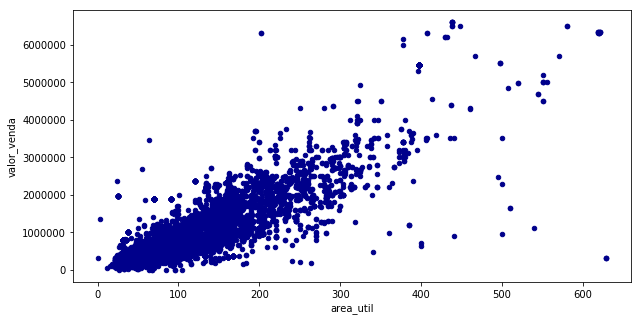

In [34]:
df_zoom = df.loc[df.area_util < 751]
ax2 = df_zoom.plot.scatter(x='area_util',
                       y='valor_venda',
                       c='DarkBlue')

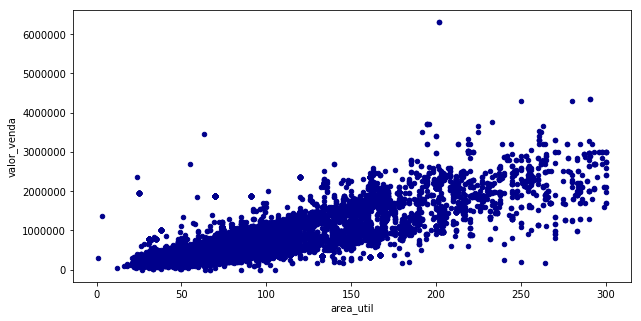

In [35]:
df_zoom = df.loc[df.area_util < 301]
ax2 = df_zoom.plot.scatter(x='area_util',
                       y='valor_venda',
                       c='DarkBlue')

(21897, 17)


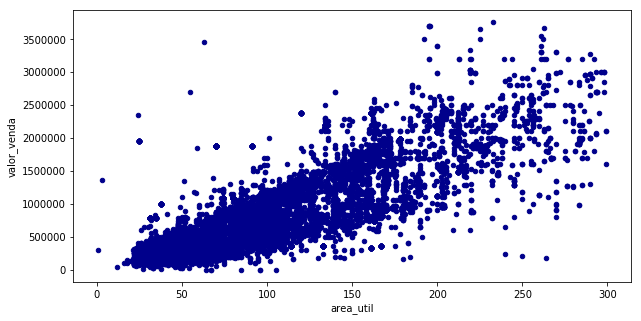

In [36]:
df_zoom = df.loc[(df.area_util < 300) & (df.valor_venda < 4000000)]
print(df_zoom.shape)
ax2 = df_zoom.plot.scatter(x='area_util',
                       y='valor_venda',
                       c='DarkBlue')